In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import brentq
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
'''Position limits for the newly introduced products:

- `VOLCANIC_ROCK`: 400

`VOLCANIC_ROCK_VOUCHER_9500` :

- Position Limit: 200
- Strike Price: 9,500 SeaShells
- Expiration deadline: 7 days (1 round = 1 day) starting from round 1

`VOLCANIC_ROCK_VOUCHER_9750` :

- Position Limit: 200
- Strike Price: 9,750 SeaShells
- Expiration deadline: 7 days (1 round = 1 day) starting from round 1

`VOLCANIC_ROCK_VOUCHER_10000` :

- Position Limit: 200
- Strike Price: 10,000 SeaShells
- Expiration deadline: 7 days (1 round = 1 day) starting from round 1

`VOLCANIC_ROCK_VOUCHER_10250` :

- Position Limit: 200
- Strike Price: 10,250 SeaShells
- Expiration deadline: 7 days (1 round = 1 day) starting from round 1

`VOLCANIC_ROCK_VOUCHER_10500` :

- Position Limit: 200
- Strike Price: 10,500 SeaShells
- Expiration deadline: 7 days (1 round = 1 day) starting from round 1'''


class Product:
    ROCK = 'VOLCANIC_ROCK'
    VOUCHER_9500 = 'VOLCANIC_ROCK_VOUCHER_9500'
    VOUCHER_9750 = 'VOLCANIC_ROCK_VOUCHER_9750'
    VOUCHER_10000 = 'VOLCANIC_ROCK_VOUCHER_10000'
    VOUCHER_10250 = 'VOLCANIC_ROCK_VOUCHER_10250'
    VOUCHER_10500 = 'VOLCANIC_ROCK_VOUCHER_10500'

position_limits = {
    Product.ROCK: 400,
    Product.VOUCHER_9500: 200,
    Product.VOUCHER_9750: 200,
    Product.VOUCHER_10000: 200,
    Product.VOUCHER_10250: 200,
    Product.VOUCHER_10500: 200
}

In [9]:
# Cell 2: Load and filter CSVs for relevant products
voucher_products = [
    "VOLCANIC_ROCK",
    "VOLCANIC_ROCK_VOUCHER_9500",
    "VOLCANIC_ROCK_VOUCHER_9750",
    "VOLCANIC_ROCK_VOUCHER_10000",
    "VOLCANIC_ROCK_VOUCHER_10250",
    "VOLCANIC_ROCK_VOUCHER_10500"
]

# Load all 3 price files
df0 = pd.read_csv("./round3/prices_round_3_day_0.csv", sep=";")
df1 = pd.read_csv("./round3/prices_round_3_day_1.csv", sep=";")
df2 = pd.read_csv("./round3/prices_round_3_day_2.csv", sep=";")

# add day * 1 MM to each timestamp
df0["timestamp"] = df0["timestamp"].apply(lambda x: int(x) + 1000000 * 0)
df1["timestamp"] = df1["timestamp"].apply(lambda x: int(x) + 1000000 * 1)
df2["timestamp"] = df2["timestamp"].apply(lambda x: int(x) + 1000000 * 2)

# Combine into one DataFrame
df = pd.concat([df0, df1, df2], ignore_index=True)

# Keep only relevant products
# df = df[df["product"].isin(voucher_products)]
df = df[df["product"].isin(voucher_products)]


# average mid_price
# df = df.groupby(["timestamp", "product"], as_index=False)["mid_price"].mean()

# each product becomes a column
df_pivot = df.pivot(index="timestamp", columns="product", values="mid_price").reset_index()

# Preview the structure
df.head()
# df.tail()



,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,VOLCANIC_ROCK_VOUCHER_10500,99.0,19.0,NaN,NaN,NaN,NaN,100,19,NaN,NaN,NaN,NaN,99.5,0.0
4,0,0,VOLCANIC_ROCK_VOUCHER_10000,505.0,19.0,NaN,NaN,NaN,NaN,506,19,NaN,NaN,NaN,NaN,505.5,0.0
6,0,0,VOLCANIC_ROCK_VOUCHER_9750,754.0,19.0,NaN,NaN,NaN,NaN,755,19,NaN,NaN,NaN,NaN,754.5,0.0
9,0,0,VOLCANIC_ROCK_VOUCHER_9500,1003.0,19.0,NaN,NaN,NaN,NaN,1004,19,NaN,NaN,NaN,NaN,1003.5,0.0
11,0,0,VOLCANIC_ROCK_VOUCHER_10250,273.0,19.0,NaN,NaN,NaN,NaN,274,19,NaN,NaN,NaN,NaN,273.5,0.0


In [10]:
# Cell 3: Compute TTE as linear decay from 8 to 5 days
timestamps = df_pivot["timestamp"].values
day = 3
t_min = timestamps.min()
t_max = timestamps.max()

# Linearly interpolate TTE between 8 and 5 days over the full timestamp range
# df_pivot["tte"] = 8 - 1 * (timestamps - t_min) / (t_max - t_min)
df_pivot["tte"] = (8 - timestamps / 1_000_000) / 365

# Optional: preview the TTE alongside timestamp
df_pivot[["timestamp", "tte"]].head()


product,timestamp,tte
0,0,0.021918
1,100,0.021918
2,200,0.021917
3,300,0.021917
4,400,0.021917


In [6]:
# Cell 4: Define Black-Scholes call pricing and implied volatility solver

def bs_call_price(S, K, T, sigma):
    """Black-Scholes call option price (r ≈ 0)."""
    if T <= 0 or sigma <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * norm.cdf(d2)

def implied_vol(C, S, K, T):
    """Compute implied volatility via Brent's method."""
    if C <= 0 or S <= 0 or T <= 0:
        return np.nan
    def objective(sigma):
        return bs_call_price(S, K, T, sigma) - C
    try:
        return brentq(objective, 1e-4, 3.0)
    except ValueError:
        return np.nan



In [7]:
# Cell 5: Compute m_t and v_t for all vouchers
m_t_vals = []
v_t_vals = []

rock_col = "VOLCANIC_ROCK"
voucher_strikes = {
    9500:  "VOLCANIC_ROCK_VOUCHER_9500",
    9750:  "VOLCANIC_ROCK_VOUCHER_9750",
    10000: "VOLCANIC_ROCK_VOUCHER_10000",
    10250: "VOLCANIC_ROCK_VOUCHER_10250",
    10500: "VOLCANIC_ROCK_VOUCHER_10500"
}

# make m_t_vals and v_t_vals separate for each voucher
# for each voucher, calculate m_t and v_t

m_t_vals_dict = {k: [] for k in voucher_strikes.keys()}
v_t_vals_dict = {k: [] for k in voucher_strikes.keys()}    

# for each voucher, calculate m_t and v_t
for K, col in voucher_strikes.items():
    df_valid = df_pivot[[rock_col, col, "tte"]].dropna()
    for _, row in df_valid.iterrows():
        S = row[rock_col]
        V = row[col]
        T = row["tte"]
        m_t = np.log(K / S) / np.sqrt(T)
        v_t = implied_vol(V, S, K, T)
        if not np.isnan(v_t):
            m_t_vals_dict[K].append(m_t)
            v_t_vals_dict[K].append(v_t)
            m_t_vals.append(m_t)
            v_t_vals.append(v_t)

# for K, col in voucher_strikes.items():
#     df_valid = df_pivot[[rock_col, col, "tte"]].dropna()
#     for _, row in df_valid.iterrows():
#         S = row[rock_col]
#         V = row[col]
#         T = row["tte"]
#         m_t = np.log(K / S) / np.sqrt(T)
#         v_t = implied_vol(V, S, K, T)
#         if not np.isnan(v_t):
#             m_t_vals.append(m_t)
#             v_t_vals.append(v_t)


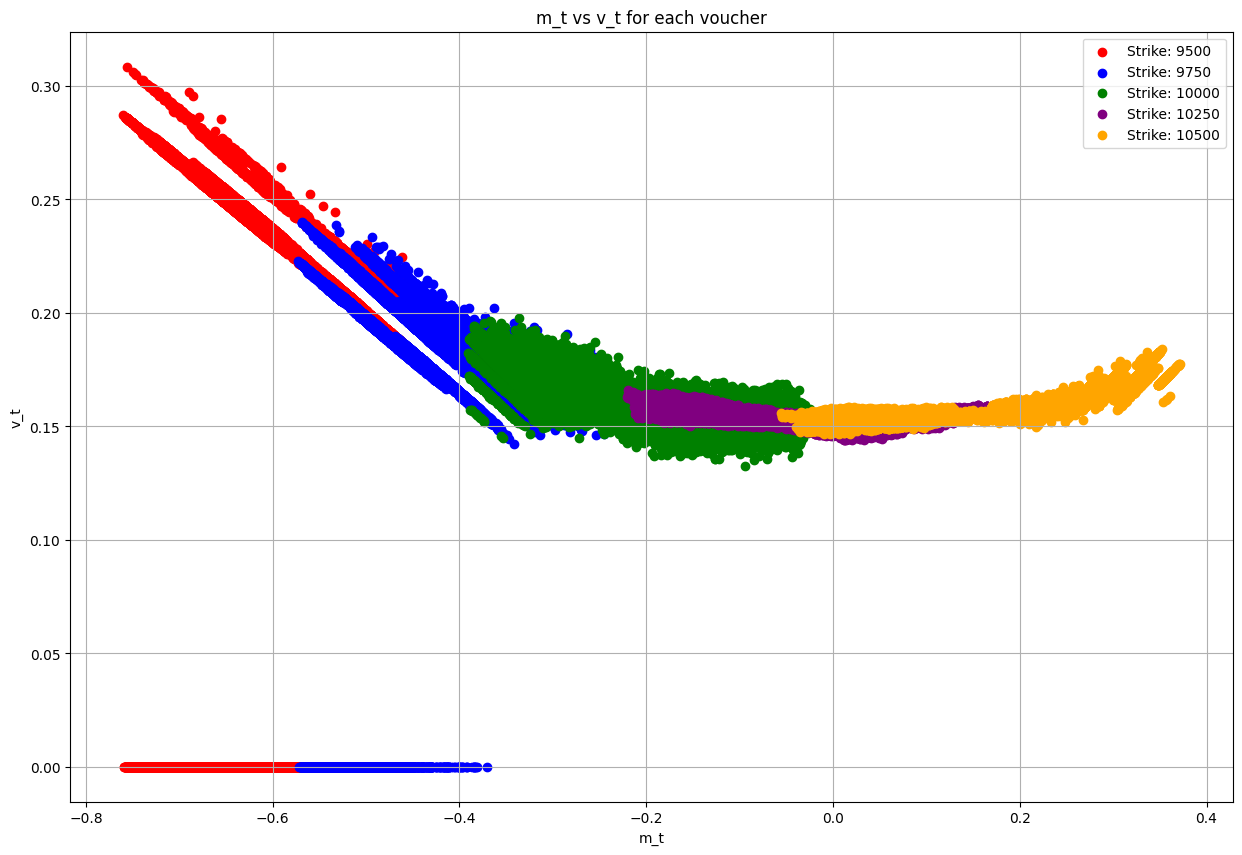

In [8]:
# plot m_t_vals_dict and v_t_vals_dict
# make each voucher a different color
colors = ["red", "blue", "green", "purple", "orange"]
plt.figure(figsize=(15, 10))
for i, (K, col) in enumerate(voucher_strikes.items()):
    plt.scatter(m_t_vals_dict[K], v_t_vals_dict[K], label=f"Strike: {K}", color=colors[i])

plt.xlabel("m_t")
plt.ylabel("v_t")

plt.title("m_t vs v_t for each voucher")
plt.legend()
plt.grid()
plt.show()

In [175]:
m_t_vals_parabola = m_t_vals
v_t_vals_parabola = v_t_vals

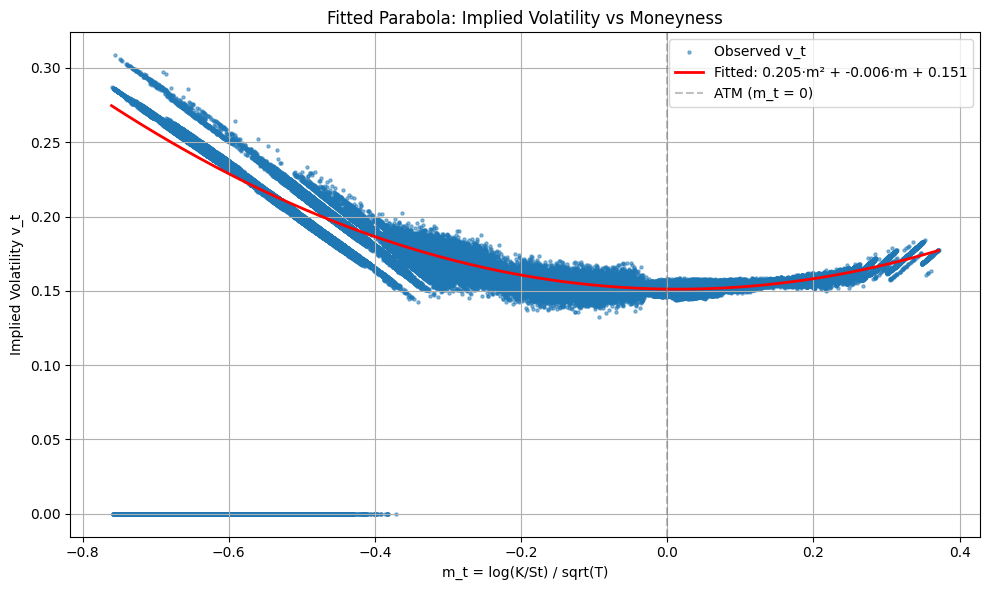

In [176]:
# Cell 6: Fit a parabolic curve to (m_t, v_t) and plot it

# Ensure data is available
if len(m_t_vals_parabola) == 0:
    print("No data available to fit parabola.")
else:
    # ingore outliers
    m_t_vals_parabola = np.array(m_t_vals)
    v_t_vals_parabola = np.array(v_t_vals)

    # Remove all vals where v_t is 0
    mask = m_t_vals_parabola > 0
    m_t_vals_parabola = m_t_vals_parabola[mask]
    v_t_vals_parabola = v_t_vals_parabola[mask]


    # Prepare X (m_t) and y (v_t)
    X = np.array(m_t_vals_parabola).reshape(-1, 1)
    y = np.array(v_t_vals_parabola)

    # Create polynomial features (degree 2)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)

    # Fit linear regression to polynomial features
    model = LinearRegression()
    model.fit(X_poly, y)

    # Extract coefficients
    a = model.coef_[2]
    b = model.coef_[1]
    c = model.intercept_

    # Generate smooth curve for plotting
    m_range = np.linspace(min(m_t_vals), max(m_t_vals), 500)
    v_fit = a * m_range**2 + b * m_range + c

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(m_t_vals, v_t_vals, s=5, alpha=0.5, label="Observed v_t")
    plt.plot(m_range, v_fit, color='red', linewidth=2, label=f"Fitted: {a:.3f}·m² + {b:.3f}·m + {c:.3f}")
    plt.axvline(0, linestyle='--', color='gray', alpha=0.5, label="ATM (m_t = 0)")
    plt.title("Fitted Parabola: Implied Volatility vs Moneyness")
    plt.xlabel("m_t = log(K/St) / sqrt(T)")
    plt.ylabel("Implied Volatility v_t")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [177]:
# Cell 7: Compute base IV over time using rolling time windows

base_iv_times = []
base_iv_values = []

window_size = 60  # seconds (adjust as needed)
step_size = 30    # seconds (how often to step the window)

timestamps = df_pivot["timestamp"].values
start_time = timestamps.min()
end_time = timestamps.max()

# Loop through time in steps
for t in range(start_time, end_time - window_size, step_size):
    window_df = df_pivot[(df_pivot["timestamp"] >= t) & (df_pivot["timestamp"] < t + window_size)]
    
    if len(window_df) < 5:
        continue  # skip windows with insufficient data

    m_t_vals = []
    v_t_vals = []

    for _, row in window_df.iterrows():
        for K, col in voucher_strikes.items():
            if pd.notna(row["VOLCANIC_ROCK"]) and pd.notna(row[col]):
                S = row["VOLCANIC_ROCK"] / 10000
                V = row[col] / 10000
                K_scaled = K / 10000
                T_days = row["tte"]
                T = T_days / 365.0
                if S <= 0 or V <= 0 or T <= 0:
                    continue
                m_t = np.log(K_scaled / S) / np.sqrt(T)
                v_t = implied_vol(V, S, K_scaled, T)
                if not np.isnan(v_t):
                    m_t_vals.append(m_t)
                    v_t_vals.append(v_t)

    if len(m_t_vals) >= 5:
        X = np.array(m_t_vals)
        y = np.array(v_t_vals)
        try:
            from scipy.optimize import curve_fit
            def parabola(m, a, b, c): return a * m**2 + b * m + c
            popt, _ = curve_fit(parabola, X, y, bounds=([-np.inf, -np.inf, -np.inf], [0, np.inf, np.inf]))
            base_iv_times.append(t)
            base_iv_values.append(popt[2])  # fitted c = v(0)
        except:
            continue


In [178]:
# Cell 7: Compute base IV over time using rolling time windows

base_iv_times = []
base_iv_values = []

window_size = 60  # seconds (adjust as needed)
step_size = 30    # seconds (how often to step the window)

timestamps = df_pivot["timestamp"].values
start_time = timestamps.min()
end_time = timestamps.max()

# Loop through time in steps
for t in range(start_time, end_time - window_size, step_size):
    window_df = df_pivot[(df_pivot["timestamp"] >= t) & (df_pivot["timestamp"] < t + window_size)]
    
    if len(window_df) < 5:
        continue  # skip windows with insufficient data

    m_t_vals = []
    v_t_vals = []

    for _, row in window_df.iterrows():
        for K, col in voucher_strikes.items():
            if pd.notna(row["VOLCANIC_ROCK"]) and pd.notna(row[col]):
                S = row["VOLCANIC_ROCK"] / 10000
                V = row[col] / 10000
                K_scaled = K / 10000
                T_days = row["tte"]
                T = T_days / 365.0
                if S <= 0 or V <= 0 or T <= 0:
                    continue
                m_t = np.log(K_scaled / S) / np.sqrt(T)
                v_t = implied_vol(V, S, K_scaled, T)
                if not np.isnan(v_t):
                    m_t_vals.append(m_t)
                    v_t_vals.append(v_t)

    if len(m_t_vals) >= 5:
        X = np.array(m_t_vals)
        y = np.array(v_t_vals)
        try:
            from scipy.optimize import curve_fit
            def parabola(m, a, b, c): return a * m**2 + b * m + c
            popt, _ = curve_fit(parabola, X, y, bounds=([-np.inf, -np.inf, -np.inf], [0, np.inf, np.inf]))
            base_iv_times.append(t)
            base_iv_values.append(popt[2])  # fitted c = v(0)
        except:
            continue
